In [1]:
%load_ext autoreload
%autoreload 2

# packages
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from scipy.stats import spearmanr

# custom code
import sys
sys.path.append('../src/')
from utils import load_word_to_ipa, load_pairs
from atp import ATP

### English Development

The following cells generate Figure 1 (a)

In [20]:
num_children = 100

ing = [0] * 20
s = [0] * 20
d = [0] * 20

word_to_ipa = load_word_to_ipa()

for child in range(num_children):
    if child % 10 == 0:
        print(f'==== Child {child} ====')
    vocabs = list(glob.glob(f'../data/english/growth/child-{child}/*.txt'))
    vocabs = sorted(vocabs, key=lambda it: int(it.split('/')[-1].split('.txt')[0]))
    for i, vocab in enumerate(vocabs):
#         pairs = list()
#         feature_space = set()
#         for line in open(vocab, 'r'):
#             lemma, inflected, feats = line.strip().split()
#             lemma_ipa = word_to_ipa[lemma]
#             inflected_ipa = word_to_ipa[inflected]
#             feature_space.update(feats.split(';'))
#             pairs.append((lemma_ipa, inflected_ipa, tuple(feats.split(';'))))
        pairs, feature_space = load_pairs(vocab, sep=' ', preprocessing=lambda s: word_to_ipa[s])
        atp = ATP(feature_space=feature_space, apply_phonology=True)
        atp.train(pairs)
        
        suffixes = set()
        for leaf in atp.get_leaves():
            if leaf.switch_statement.productive:
                suffix = leaf.switch_statement.default_case.name.split('lemma')[-1].replace(' + ', '')
                suffixes.add(suffix)
        if 'z' in suffixes and 's' in suffixes:
            suffixes.discard('z')
        if 't' in suffixes and 'd' in suffixes:
            suffixes.discard('t')
        for suffix in suffixes:
            if suffix == 'ɪŋ':
                ing[i] += 1
            if suffix in {'d', 't'}:
                d[i] += 1
            if suffix in {'s', 'z'}:
                s[i] += 1

==== Child 0 ====
==== Child 10 ====
==== Child 20 ====
==== Child 30 ====
==== Child 40 ====
==== Child 50 ====
==== Child 60 ====
==== Child 70 ====
==== Child 80 ====
==== Child 90 ====


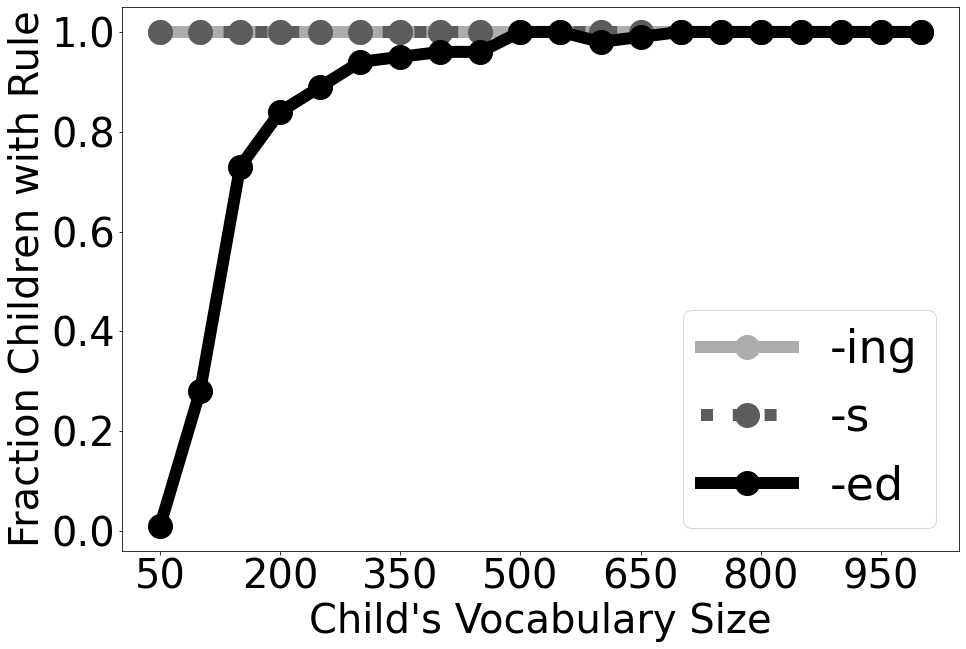

In [21]:
grays = sns.color_palette('Greys')

plt.figure(figsize=(15, 10))
fontsize=40
x = np.arange(50, 1050, 50)
Z = num_children

plt.plot(x, np.asarray(ing) / Z, '-o',  markersize=24, linewidth=12, color=grays[-4], label='-ing')
plt.plot(x, np.asarray(s) / Z, '-o',  markersize=24, linewidth=12, color=grays[-2], linestyle=':', label='-s')
plt.plot(x, np.asarray(d) / Z, '-o',  markersize=24, linewidth=12, color='black', label='-ed')

plt.legend(fontsize=fontsize + 6)
plt.xticks(np.arange(50, 1050, 150), fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Fraction Children with Rule', fontsize=fontsize)
plt.xlabel('Child\'s Vocabulary Size', fontsize=fontsize)
plt.show()

### German Development

The following cells generate Figure 1 (a)

In [ ]:
num_seeds = 100
train_sizes = [50, 100, 200, 300, 400]

en = [0] * len(train_sizes)
n = [0] * len(train_sizes)
e = [0] * len(train_sizes)
null = [0] * len(train_sizes)
er = [0] * len(train_sizes)
s = [0] * len(train_sizes)

for i, size in enumerate(train_sizes):
    for seed in range(num_seeds):
        fname = f'../data/german/growth/train{size}_{seed}.txt'
        pairs, feature_space = load_pairs(fname, 'german')
        atp = ATP(feature_space=feature_space)
        atp.train(pairs)

        suffixes = set()
        for leaf in atp.get_leaves():
            if leaf.switch_statement.productive:
                suffix = leaf.switch_statement.default_case.name.split('lemma')[-1].replace(' + ', '')
                suffixes.add(suffix)
        for suffix in suffixes:
            if suffix == 'en':
                en[i] += 1
            if suffix == 'e':
                e[i] += 1
            if suffix == 'n':
                n[i] += 1
            if suffix == '':
                null[i] += 1
            if suffix == 'er':
                er[i] += 1
            if suffix == 's':
                s[i] += 1

In [ ]:
plt.figure(figsize=(15, 10))

fontsize=40
x = train_sizes
Z = num_seeds
lw = 14
ms = 26

ca = grays

plt.plot(x, np.asarray(n) / Z, '-o', markersize=ms, linewidth=lw,    color=ca[1],  linestyle='-',  label='-n')
plt.plot(x, np.asarray(null) / Z, '-o', markersize=ms, linewidth=lw, color=ca[1],  linestyle=':',  label='-∅')
plt.plot(x, np.asarray(e) / Z, '-o',  markersize=ms, linewidth=lw,   color=ca[2],  linestyle='-',  label='-e')
plt.plot(x, np.asarray(en) / Z, '-o', markersize=ms, linewidth=lw,   color=ca[3],  linestyle=':',  label='-en')
plt.plot(x, np.asarray(er) / Z, '-o',  markersize=ms, linewidth=lw,  color=ca[4],  linestyle='-',  label='-er')
plt.plot(x, np.asarray(s) / Z, '-o',  markersize=ms, linewidth=lw,   color=ca[5],  linestyle=':',  label='-s')

plt.legend(fontsize=fontsize - 1, loc=(0.75, 0.21), facecolor='white', framealpha=1.0)

plt.xticks([100, 200, 300, 400], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Fraction Children with Rule', fontsize=fontsize)
plt.xlabel('Child\'s Vocabulary Size', fontsize=fontsize)
plt.show()

### English Performance

The following cells generate Figure 2 (a)

In [8]:
def printable_acc(accs, r=2):
    return list(np.round(np.mean(accs, axis=0), r))

num_seeds = 10
train_sizes = [100, 200, 400, 600, 800, 1000]

# accs arrays
test_accs = np.zeros((num_seeds, len(train_sizes)))
    
# irregulars stuff (for U-shape curve)
seed_to_seen_irregulars = defaultdict(set)
seed_to_irregulars_currently_covered = defaultdict(dict)
train_irregular_accs = np.zeros((num_seeds, len(train_sizes)))

for col, size in enumerate(train_sizes):
    row = 0
    for seed in range(num_seeds):
        train_path = f'../data/english/quant/unimorph_celex0_train{size}_{seed}.txt'
        test_path = train_path.replace(f"{train_path.split('_')[-2]}", 'test')
        pairs, feature_space = load_pairs(train_path)
        atp = ATP(feature_space=feature_space)
        atp.train(pairs)

        # compute accuracy
        test_accs[row, col] = atp.accuracy(load_pairs(test_path)[0])
                
        ''' begin irrgular performance '''
        # all the irregulars previously seen during training
        for pair in pairs:
            lemma, inflected, _ = pair
            if inflected != f'{lemma}d' and inflected != f'{lemma}t' and inflected != f'{lemma}ɪd':
                seed_to_seen_irregulars[seed].add(pair)

        irr_c = 0
        irr_t = 0
        for word in seed_to_seen_irregulars[seed]:
            lemma_ipa, _, feats = word
            leaf = atp.probe(lemma_ipa, feats)
            if leaf.switch_statement.productive and (word not in seed_to_irregulars_currently_covered[seed] or not seed_to_irregulars_currently_covered[seed][word]):
                seed_to_irregulars_currently_covered[seed][word] = True
            else:
                irr_c += 1
            irr_t += 1
        train_irregular_accs[row, col] = irr_c / irr_t
        ''' end irrgular performance '''
            
        row += 1

    print(f'Test = {printable_acc(test_accs)}')

Test = [0.57, 0.0, 0.0, 0.0, 0.0, 0.0]
Test = [0.57, 0.75, 0.0, 0.0, 0.0, 0.0]
Test = [0.57, 0.75, 0.88, 0.0, 0.0, 0.0]
Test = [0.57, 0.75, 0.88, 0.9, 0.0, 0.0]
Test = [0.57, 0.75, 0.88, 0.9, 0.91, 0.0]
Test = [0.57, 0.75, 0.88, 0.9, 0.91, 0.91]


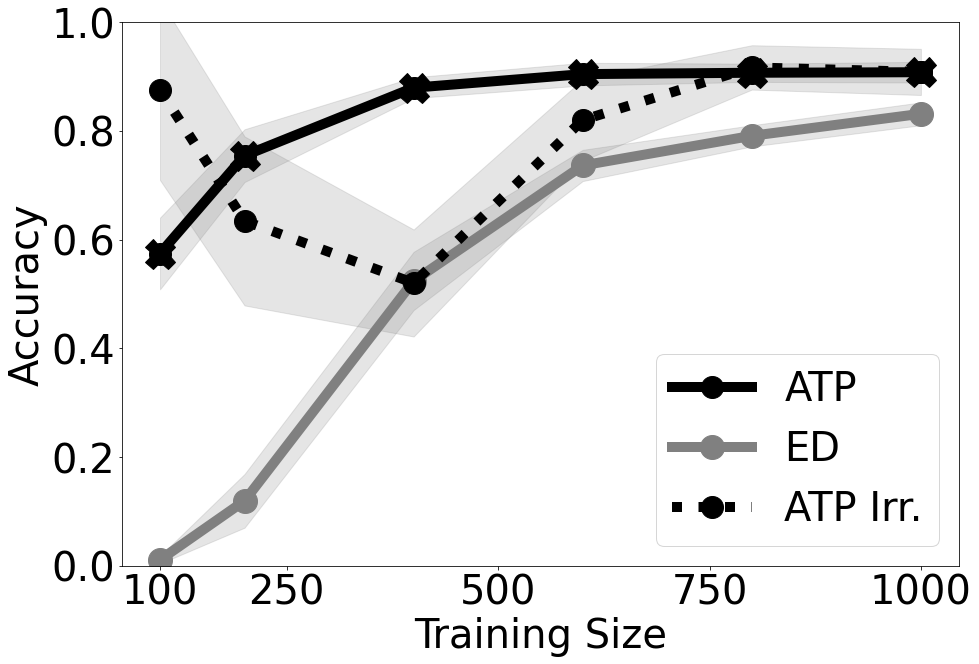

In [15]:
plt.figure(figsize=(15, 10))
fontsize=40

x = train_sizes

atp_color = 'black'
ed_color = 'gray'

atp_accs = np.mean(test_accs, axis=0)
atp_stddevs = np.std(test_accs, axis=0)

u_shape_avg = np.mean(train_irregular_accs, axis=0)
u_shape_std = np.std(train_irregular_accs, axis=0)

# load the NN results
df = pd.read_csv('../data/english/ed-output.csv')
nn_res = np.zeros((10, 6))
for seed in range(10):
    for size_idx, size in enumerate(train_sizes):
        nn_res[seed, size_idx] = float(df[(df['split'] == seed) & (df['datasize'] == size)]['test'])
nn_accs = np.mean(nn_res, axis=0)
nn_stddevs = np.std(nn_res, axis=0)


# ATP
plt.plot(x, atp_accs, '-o', markersize=22, linewidth=10, color=atp_color, label='ATP')
plt.plot(x, atp_accs, marker='X', markersize=30, color=atp_color)
plt.fill_between(x, 
                 np.asarray(atp_accs) - np.asarray(atp_stddevs), 
                 np.asarray(atp_accs) + np.asarray(atp_stddevs), color='gray', alpha=0.2)

plt.plot(x, nn_accs, '-o', markersize=24, linewidth=10, color=ed_color, label='ED')
plt.fill_between(x, 
                 np.asarray(nn_accs) - np.asarray(nn_stddevs), 
                 np.asarray(nn_accs) + np.asarray(nn_stddevs), color='gray', alpha=0.2)

plt.plot(x, u_shape_avg, '-o', markersize=22, linewidth=10, color=atp_color, linestyle=':', label='ATP Irr.')
plt.fill_between(x, 
                 np.asarray(u_shape_avg) - np.asarray(u_shape_std), 
                 np.asarray(u_shape_avg) + np.asarray(u_shape_std), color='gray', alpha=0.2)

plt.legend(fontsize=fontsize)
plt.xticks([100, 250, 500, 750, 1000], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Accuracy', fontsize=fontsize)
plt.xlabel('Training Size', fontsize=fontsize)
plt.ylim([0.0, 1.0])
plt.show()

### German Wug test

The following cells generate Table 1. While ATP is deterministic, the numbers may differ some due to arbitrariness at runtime, such as hashing.

In [18]:
df = pd.read_csv('../data/german/german_wug.csv')
df = df[df['Q_Task'] == 'production'].fillna('')

wugs = set()
wug_to_child_preds = defaultdict(list)
wug_to_rhyme = dict()
suffixes = set()
for wug, child_pred, suffix, rhyme in zip(df['Q_Lemma'], df['Q_PL_Form'], df['Q_PL_Label'], df['Q_Lemma_HasRhymes']):
    wug, child_pred = wug.capitalize(), child_pred.capitalize()
    wug = wug.replace(u'ä', 'a').replace(u'ü', 'u').replace(u'ö', 'o').replace(u'Ä', 'A').replace(u'Ü', 'U').replace(u'Ö', 'O')
    child_pred = child_pred.replace(u'ä', 'a').replace(u'ü', 'u').replace(u'ö', 'o').replace(u'Ä', 'A').replace(u'Ü', 'U').replace(u'Ö', 'O')
    
    wugs.add(wug)
    suffix = suffix.replace('umlaut_', '')
    if suffix == 'umlaut':
        suffix = 'zero'
        assert(child_pred == wug)
    wug_to_child_preds[wug].append(suffix)
    suffixes.add(suffix)
    
    if suffix == 'en':
        assert(child_pred[len(wug):] == 'en')
        
    if child_pred == f'{wug}n':
        print(child_pred, wug)
        
    wug_to_rhyme[wug] = rhyme
    
wugs = sorted(wugs)
    
wug_to_TP_preds_CHILDES_N = defaultdict(list)
wug_to_TP_preds_CHILDES_ques = defaultdict(list)

def update(result_dict, model_pred, wug):
    suffix = model_pred[len(wug):]
    if suffix == '':
        result_dict[wug].append('zero')
    elif suffix == 'n':
        result_dict[wug].append('en')
    elif suffix in suffixes:
        result_dict[wug].append(suffix)
    else:
        result_dict[wug].append('other')

for i in range(500):
    _pairs, feature_space = load_pairs(f'../data/german/growth/train400_{i}.txt')
    atp = ATP(feature_space=feature_space)
    atp.train(_pairs)
    for wug in wugs:
        update(wug_to_TP_preds_CHILDES_N, atp.inflect(wug, ('N',)), wug)
        update(wug_to_TP_preds_CHILDES_ques, atp.inflect_no_feat(wug, ()), wug)

In [19]:
def get_dist(preds):
    dist = defaultdict(int)
    for p in preds:
        dist[p] += 1
    return dict(dist)

models = {'CHILDES_N': wug_to_TP_preds_CHILDES_N, 
          'CHILDES_?': wug_to_TP_preds_CHILDES_ques}

model_res = dict()

for model_name, model in models.items():
    suffix_to_percentage_R = defaultdict(int)
    suffix_to_percentage_NR = defaultdict(int)
    pearsons = dict()
    Z_R = 0
    Z_NR = 0

    for s in suffixes:
        child_p = list()
        model_p = list()
        for wug in wugs:
            child_dist = get_dist(wug_to_child_preds[wug])
            model_dist = get_dist(model[wug]) # Neuter with analogy
            child_p.append((child_dist[s] / sum(child_dist.values()) if s in child_dist else 0))
            model_p.append((model_dist[s] / sum(model_dist.values()) if s in model_dist else 0))

            if s in model_dist:
                if wug_to_rhyme[wug]:
                    suffix_to_percentage_R[s] += model_dist[s]
                    Z_R += model_dist[s]
                else:
                    suffix_to_percentage_NR[s] += model_dist[s]
                    Z_NR += model_dist[s]
                    
        rho = spearmanr(child_p, model_p)
        if rho.pvalue < 0.05:
            pearsons[s] = f'{round(rho.correlation, 2)}*'
        else:
            pearsons[s] = rho.correlation
            
    for s in suffix_to_percentage_R:
        suffix_to_percentage_R[s] /= Z_R

    for s in suffix_to_percentage_NR:
        suffix_to_percentage_NR[s] /= Z_NR
        
    model_res[model_name] = {'R': dict(suffix_to_percentage_R), 
                             'NR': dict(suffix_to_percentage_NR), 
                             'rho': dict(pearsons)}

metrics = ['R', 'NR', 'rho']

def get_res_for_suffix(suf):
    return list(model_res['CHILDES_N'][metric][suf] if suf in model_res['CHILDES_N'][metric] else '' for metric in metrics) + list(model_res['CHILDES_?'][metric][suf] if suf in model_res['CHILDES_?'][metric] else '' for metric in metrics)

def pretty(vals):
    return list(round(v, 2) if type(v) is not str else v for v in vals)

en_row = pretty(get_res_for_suffix('en'))
e_row = pretty(get_res_for_suffix('e'))
zero_row = pretty(get_res_for_suffix('zero'))
er_row = pretty(get_res_for_suffix('er'))
s_row = pretty(get_res_for_suffix('s'))
other_row = pretty(get_res_for_suffix('other'))

pd.DataFrame.from_dict({'': ['%R', '%NR', 'rho', '%R', '%NR', 'rho'],
                        '-(e)n': en_row, 
                        '-e': e_row,
                        '-zero': zero_row,
                        '-er': er_row,
                        '-s': s_row,
                        'other': other_row},
                       columns=['', '', 'A', '', 'D', ''],
                       orient='index')

/Users/caleb/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,,,A,,D,
,%R,%NR,rho,%R,%NR,rho
-(e)n,0.17,0.03,-0.22,0.19,0.23,0.42*
-e,0.27,0.32,-0.13,0.45,0.61,0.01
-zero,0.11,0.03,0.47*,0.07,,0.55*
-er,0.41,0.09,0.59*,0.29,0,0.46*
-s,0.03,0.52,0.3,0.01,0.15,0.64*
other,,,NaN,,,NaN
